# Guerra Mundial RS

## Imports
We start importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt

And initializing the visualization set

In [2]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
%matplotlib inline

## Shapefile structure

We will use a variable to configure the shapefile path, making sure you have the files in your local folder

In [3]:
shp_path = "./Municipio.shp"
sf = shp.Reader(shp_path)

This is a record example structure

In [4]:
sf.records()[231]

Record #231: ['Carlos Barbosa', '4304804', 1959, 'Carlos Barbosa', 'Sim']

## Helper functions

We will use a function to convert a shapefile to a Pandas DF object

In [5]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    df = df.assign(owner=df.nome)
    df = df.assign(centre=[get_city_centre(df, city_name) for city_name in df['nome']])
    return df

We have some function to compute data for each city, such as:

* their XY coordinates
* their center
* the distance between two points (two city centres)
* the distance from a city to all other cities in a list

In [6]:
def get_city_coordinates(df, city_name):
    """
    From a city_name, return its XY coordinates
    """
    # Fetch the shape coordinates
    shape = df[df.nome == city_name].coords.to_numpy()[0]
    x_lon = [point[0] for point in shape]
    y_lat = [point[1] for point in shape]
    
    return x_lon, y_lat

In [7]:
def get_city_centre(df, city_name):
    """
    From a city_name, return its center coordinates
    """
    
    # Fetch the shape information
    return np.mean(get_city_coordinates(df, city_name), 1)    

In [8]:
def haversine_distance(x0, y0, x1, y1):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x0, y0, x1, y1])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    
    return c * r

In [9]:
def distance_to_other_cities(df, city):
    """
    Returns the Haversine distance for each city
    in relation to a given city, sorted by distance
    """
    city_centre = df[df.nome == city].centre.to_numpy()[0]
    distance = [(haversine_distance(*city_centre, *df[df.nome ==
                                                      other_city].centre.to_numpy()[0]), other_city,) for other_city in df.nome]
    
    return sorted(distance, key=lambda x: x[0])

We also use a function to plot a single shape

In [10]:
def plot_city(df, city_name):
    """ Plots a single shape """
    
    # Configure the plot
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    
    # Fetch and plot the shape
    x_lon, y_lat = get_city_coordinates(df, city_name)
    plt.plot(x_lon,y_lat) 
    
    # Configure the text plotting
    x_center, y_center = get_city_centre(df, city_name)
    plt.text(x_center, y_center, city_name, fontsize=10)

And a function to plot a map, and cities, by color

In [11]:
def plot_map_fill(sf, df, cities, title, 
                                  x_lim = None, 
                                  y_lim = None, 
                                  figsize = (11,9)):
    '''
    Plot map with lim coordinates, and the cities asked with their correspondent color
    '''
    
    # Configure the plot
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    
    # Plot all the cities in the map
    for shape in sf.shapeRecords():
        x = [point[0] for point in shape.shape.points[:]]
        y = [point[1] for point in shape.shape.points[:]]
        ax.plot(x, y, 'k')
    
    # Plot the cities
    for city_name, color in cities:
        x_lon, y_lat = get_city_coordinates(df, city_name)
        ax.fill(x_lon, y_lat, color)
        
        x_center, y_center = get_city_centre(df, city_name)
        plt.text(x_center, y_center, city_name, fontsize=10)
    
    # Configure the map size
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

# Experiments

Here we have some space to test some stuff

In [12]:
df = read_shapefile(sf)
df

,nome,geocodigo,anoDeRefer,nomeAbrev,d_geometri,coords,owner,centre
0,Quaraí,4315305,1875,Quaraí,Sim,"[(-56.04483493099997, -30.049016369999947), (-...",Quaraí,"[-56.139744860368275, -30.277528926007495]"
1,Tuparendi,4322301,1959,Tuparendi,Sim,"[(-54.582405377999976, -27.589248864999945), (...",Tuparendi,"[-54.559122271563005, -27.686690801921934]"
2,Turuçu,4322327,1995,Turuçu,Sim,"[(-52.20587021299997, -31.376959297999974), (-...",Turuçu,"[-52.11795457770213, -31.553730516174838]"
3,Bom Jesus,4302303,1913,Bom Jesus,Sim,"[(-50.71894901999997, -28.26114945699993), (-5...",Bom Jesus,"[-50.517930127111434, -28.50676956560769]"
4,Capão da Canoa,4304630,1982,Capão da Canoa,Sim,"[(-49.991792000999965, -29.606068998999945), (...",Capão da Canoa,"[-50.01279731865671, -29.644739373324153]"
5,Chuvisca,4305447,1995,Chuvisca,Sim,"[(-51.97663894899995, -30.660451812999952), (-...",Chuvisca,"[-52.012816626406, -30.78654048226133]"
6,Coronel Bicaco,4305900,1963,Cel. Bicaco,Sim,"[(-53.73567824199995, -27.660281673999975), (-...",Coronel Bicaco,"[-53.67358112523211, -27.843061892520428]"
7,Forquetinha,4308433,1996,Forquetinha,Sim,"[(-52.16307645099994, -29.329481055999963), (-...",Forquetinha,"[-52.1489944520316, -29.393849310823484]"
8,Fortaleza dos Valos,4308458,1982,Fortaleza dos Valos,Sim,"[(-53.284034314999985, -28.724480907999975), (...",Fortaleza dos Valos,"[-53.33885093078541, -28.8895100584575]"
9,Frederico Westphalen,4308508,1954,Frederico Westphalen,Sim,"[(-53.32702393799997, -27.221732372999952), (-...",Frederico Westphalen,"[-53.28712898107338, -27.33042438073956]"


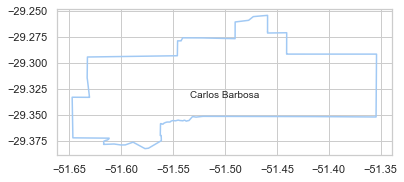

In [13]:
plot_city(df, 'Carlos Barbosa')

<Figure size 792x648 with 0 Axes>

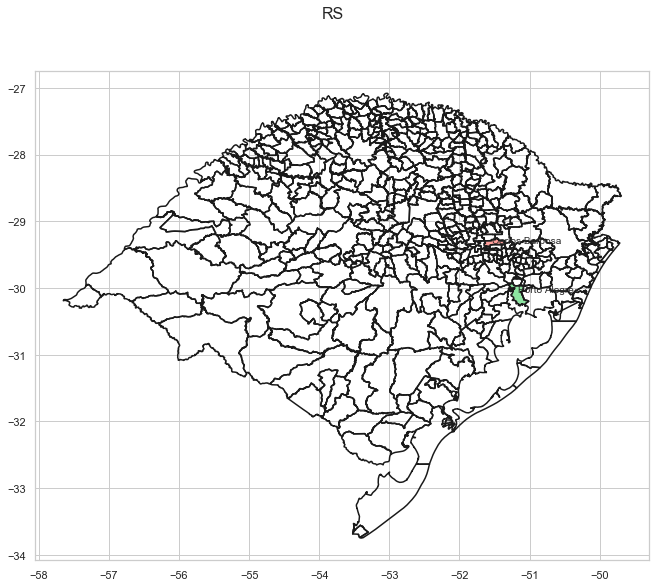

In [14]:
plot_map_fill(sf, df, [('Carlos Barbosa', 'r'), ('Porto Alegre', 'g')], 'RS')

In [15]:
get_city_centre(df, 'Carlos Barbosa')

array([-51.53354743, -29.33345699])

# Guerra testing

Here we try some testing seeing who will win this war

In [ ]:
# Precompute the distances
DISTANCES = {}

with tqdm(df['nome']) as t:
    for city_name in t:
        t.set_description(city_name)
        DISTANCES[city_name] = distance_to_other_cities(df, city_name)

Carazinho:  45%|███████████████████████████████▍                                     | 226/497 [01:53<02:38,  1.71it/s]

In [ ]:
winners = {}
time = []
for i in tqdm(range(10000)):
    # Re-fetch the dataset
    df = df.assign(owner=df.nome)

    # Run the simulation
    runners = []
    while len(df['owner'].unique()) > 1:

        # Update quantity of runners
        runners.append(len(df['owner'].unique()))

        # Get the reference to the attacking city
        attack_city = df.sample()

        # Get the reference to the attacking city owner
        attack_city_owner = df[df.nome == attack_city.owner.to_numpy()[0]]

        # Get the attacking city name
        attack_name = attack_city.nome.to_numpy()[0]

        # Get the distance to the other cities
        distance_to_cities = DISTANCES[attack_name]

        # Get the names from all cities under the same owner
        owned_by_same = df[df.owner == attack_city_owner.nome.to_numpy()[0]].nome.to_numpy()

        # Get the name of the first city, in distance, which is not owned by the same guy
        defend_name = next(city[1] for city in distance_to_cities if city[1] not in owned_by_same and city[1])

        # Get its correspondent reference
        defend_city = df[df.nome == defend_name]

        # Get its owner
        defend_city_owner = df[df.nome == defend_city.owner.to_numpy()[0]]

        # Print information
        # print("{} conquers {} from {} through {}".format(attack_city_owner.nome.to_numpy()[0], defend_name, defend_city_owner.nome.to_numpy()[0], attack_name))

        # Update the city owner
        df.loc[df['nome'] == defend_name, ['owner']] = attack_city_owner.nome.to_numpy()[0]
    
    winner_name = df['owner'].to_numpy()[0]
    winners[winner_name] = winners[winner_name] + 1 if winner_name in winners else 1
    time.append(len(runners))

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(runners)

In [ ]:
plt.bar(list(winners.keys()), list(winners.values()))